<a href="https://colab.research.google.com/github/kevincong95/cs231n-emotiw/blob/master/notebooks/2.3-la-tj-ak-kc-variational-autoencoder-fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Sentiment Analysis in the Wild
### Ensembling Notebook | Variational Autoencoder Fusion | CS231n

This notebook runs a more complex Variational Autoencoder Fusion model on the predicted outputs of each individual modality. Assumes the preprocessing has already been completed.

Contains:
- Frame
- Audio
- Pose


# Preprocessing


### Are we working with the tiny dataset or the final dataset?

In [0]:
IS_TINY = False

### Copy Pre-Processed Files

In [0]:
!ls

sample_data


## Run this if you are working with concatenations not written to disk

In [0]:

# FULL_PATH = 'My Drive/cs231n-project/datasets/emotiw'
FULL_PATH = 'My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw'
if IS_TINY:
    print("Using tiny dataset...")
    !cp /content/drive/'$FULL_PATH'/train-tiny-* .
    !cp /content/drive/'$FULL_PATH'/val-tiny-* .
else:
    print("Using final dataset...")
    !cp /content/drive/'$FULL_PATH'/train-final-* .
    !cp /content/drive/'$FULL_PATH'/val-final-* .

!wget https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt
!wget https://storage.googleapis.com/cs231n-emotiw/data/Val_labels.txt


NameError: ignored

In [0]:
!ls

drive				   ensemble-scene-pose-audio-face-v2.zip
ensemble-scene-pose-audio-face-v2  sample_data


In [0]:
# RUN THIS FOR TINY FILES (zip does not include root folder)

if IS_TINY:
    !unzip -d train-tiny-audio train-tiny-audio.zip
    !unzip -d train-tiny-faces train-tiny-faces.zip
    !unzip -d train-tiny-frames train-tiny-frames.zip
    !unzip -d train-tiny-pose train-tiny-pose.zip

    !unzip -d val-tiny-audio val-tiny-audio.zip
    !unzip -d val-tiny-faces val-tiny-faces.zip
    !unzip -d val-tiny-frames val-tiny-frames.zip
    !unzip -d val-tiny-pose val-tiny-pose.zip


# RUN THIS FOR FINAL FILES (zip includes root folder)

if not IS_TINY:
    !unzip train-final-audio.zip
    !unzip train-final-faces.zip
    !unzip train-final-frames.zip
    !unzip train-final-pose.zip
    !unzip -d train-final-fer train-final-fer.zip

    !unzip val-final-audio.zip
    !unzip val-final-faces.zip
    !unzip val-final-frames.zip
    !unzip val-final-pose.zip
    !unzip -d val-final-fer val-final-fer.zip


In [0]:
!ls

drive		       train-final-frames      val-final-faces
sample_data	       train-final-frames.zip  val-final-faces.zip
train-final-audio      train-final-pose        val-final-frames
train-final-audio.zip  train-final-pose.zip    val-final-frames.zip
train-final-faces      Train_labels.txt        val-final-pose
train-final-faces.zip  val-final-audio	       val-final-pose.zip
train-final-fer.zip    val-final-audio.zip     Val_labels.txt


### Run Classifiers

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [0]:
!pwd

/content


In [0]:
!git clone 'https://github.com/kevincong95/cs231n-emotiw.git'

Cloning into 'cs231n-emotiw'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 880 (delta 115), reused 100 (delta 43), pack-reused 683
Receiving objects: 100% (880/880), 186.80 MiB | 35.68 MiB/s, done.
Resolving deltas: 100% (523/523), done.


In [0]:
!mv train-* cs231n-emotiw
!mv val-* cs231n-emotiw

In [0]:
!mv Train* cs231n-emotiw
!mv Val* cs231n-emotiw

In [0]:
!ls

cs231n-emotiw  drive  sample_data


In [0]:
import os
os.chdir('/content/cs231n-emotiw')
!pwd

/content/cs231n-emotiw


In [0]:
# Create the concatenated input layer to feed into FC

from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.face_classifer import FaceClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

def run_classifier(layers_to_extract, audio_folder='train-final-audio', frames_folder='train-final-frames', pose_folder='train-final-pose', labels_file="Train_labels.txt"):
    audio_classifier = AudioClassifier(audio_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
    frames_classifier = FramesClassifier(frames_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
    pose_classifier = PoseClassifier(pose_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)
    
    classifiers = [audio_classifier, frames_classifier, pose_classifier]

    sample_to_true_label = {}
    with open(labels_file) as f:
        l = 0
        for line in f:
            if l == 0:
                # Skip headers
                l += 1
                continue
            line_arr = line.split(" ")
            sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip()) - 1 # subtract one to make labels from 0 to 2
            l += 1

    classifier_outputs = []
    classifier_samples = []
    classifier_dim_sizes = []
    output_dim_size = 0
    num_samples = 0
    sample_to_row = {}

    for i, classifier in enumerate(classifiers):
        output, samples = classifier.predict(layers_to_extract[i])
        output_dim_size += output.shape[1]
        classifier_dim_sizes.append(output.shape[1])
        num_samples = len(samples)
        classifier_outputs.append(output)
        classifier_samples.append(samples)


    X_train = np.zeros(shape=(num_samples, output_dim_size))
    y_train = []

    print(f"Number of samples: {num_samples}")
    print(f"Dim shapes: ")
    print(classifier_dim_sizes)

    for i, sample in enumerate(classifier_samples[0]):
        sample_to_row[sample] = i
        y_train.append(sample_to_true_label[sample])

    last_classifier_index = 0
    for c, output in enumerate(classifier_outputs):
        samples = classifier_samples[c]
        print(len(output))
        for i, row in enumerate(output):
            sample = samples[i]
            X_train[sample_to_row[sample], last_classifier_index:last_classifier_index+classifier_dim_sizes[c]] += row
        last_classifier_index += classifier_dim_sizes[c]

    return X_train, tf.keras.utils.to_categorical(y_train, num_classes=3)





In [0]:
import tensorflow as tf

# For each classifier, extract the specific desired layer 
# (refer to the model summary for the layer names)

layers_to_extract = [
    "dense",
    "concatenate_5",
    "bidirectional_1",
    
]

prefix = "final"
if IS_TINY:
    prefix = "tiny"

X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose", labels_file="Train_labels.txt")
X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose", labels_file="Val_labels.txt")

print(X_train.shape)
print(y_train.shape)

AudioClassifier created with audio_folder = train-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = train-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = train-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a folder
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Customizing model by returning layer concatenate_5
Skipping unzipping files as input is a folder
['2', '1', '3']
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Customiz

/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)
/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)


Number of samples: 2661
Dim shapes: 
[32, 30, 128]
2661
2661
2661
AudioClassifier created with audio_folder = val-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = val-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = val-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a folder
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7
Customizing model by returning layer concatenate_5
Skipping unzipping files as input is a folder
['2', '1', '3']
Found 766 frames belonging to 766 videos belong

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Number of samples: 766
Dim shapes: 
[32, 30, 128]
766
766
766
(2661, 190)
(2661, 3)


In [0]:
y_train = np.argmax(Y_train, axis=1) + 1
y_valid = np.argmax(Y_valid, axis=1) + 1

In [0]:
y_train_np = y_train - 1
y_val_np = y_valid - 1 

In [0]:
!ls

drive				   ensemble-scene-pose-audio-face-v2.zip
ensemble-scene-pose-audio-face-v2  sample_data


## Load Pre-Classified Ensembling
Because I don't want to wait around for the model to predict everything again

Pre-Classified in: https://colab.research.google.com/drive/1rAlIfrP4exQ8m4mUIARAag4xlF-rQnHf?authuser=3#scrollTo=VY0tll5ybslJ

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Cheat load pre-classified ensembling input
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw/ensemble-scene-pose-audio-face.zip .
!unzip ensemble-scene-pose-audio-face.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  ensemble-scene-pose-audio-face.zip
replace ensemble-scene-pose-audio-face/y_valid.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!ls ensemble-scene-pose-audio-face

In [0]:
import numpy as np

!cp 'drive/My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw/ensemble-scene-pose-audio-face-v2.zip' .
!unzip ensemble-scene-pose-audio-face-v2.zip


Archive:  ensemble-scene-pose-audio-face-v2.zip
replace ensemble-scene-pose-audio-face-v2/y_valid.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:

X_train = np.load("ensemble-scene-pose-audio-face-v2/X_train.npy")
Y_train = np.load("ensemble-scene-pose-audio-face-v2/y_train.npy")
X_valid = np.load("ensemble-scene-pose-audio-face-v2/X_valid.npy")
Y_valid = np.load("ensemble-scene-pose-audio-face-v2/y_valid.npy")



In [0]:
y_train = np.argmax(Y_train, axis=1) + 1
y_valid = np.argmax(Y_valid, axis=1) + 1

# Variational Autoencoder

This code was adapted from the Keras Convolutional VAE tutorial.

In [0]:
y_train_np = y_train - 1
y_valid_np = y_valid - 1

In [0]:
# Variational Autoencoders
# - These are probabalistic autoencoders meaning the output is partly determined by chance
# - These are generative and can generate **new** inputs just by looking at the training set. 
# 
# There are 2 loss functions
# - 1. Reconstruction loss (usual)
# - 2. Latent loss: This pushes the autoencoder to have codings that look like they were sampled from a '
#       guassian distribution. It is the **divergence** between the target distr and the actual distribution of
#       codings.
#       L = -1/2(sum(1+ log(sigma^2) - sigma^2 - mu^2)) or 
#       L = -1/2sum(1 + gamma - exp(gamma) - mu^2) where gamma = log(sigma^2)

In [0]:
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

In [0]:
import cv2

from sklearn.preprocessing import Normalizer , StandardScaler , MinMaxScaler

norm = StandardScaler() #Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_val_norm = norm.fit_transform(X_valid)

def reshape_X(input_x):
  X_train_expand = np.expand_dims(input_x , axis=1)
  all_expanded_x = []
  for x in X_train_expand:
    X_sample_train = np.concatenate([x]*310)
    X_sample_train = cv2.resize(X_sample_train, (28, 28))
    all_expanded_x.append(X_sample_train)

    
  all_expanded_x = np.asarray(all_expanded_x, dtype='float32')
  all_expanded_x = np.expand_dims(all_expanded_x , axis=3)
  
  return all_expanded_x


X_train_img = reshape_X(X_train_norm)
X_val_img = reshape_X(X_val_norm)
print(X_val_img.shape)






(766, 28, 28, 1)


## Visualize the Concatenated Layers as Images

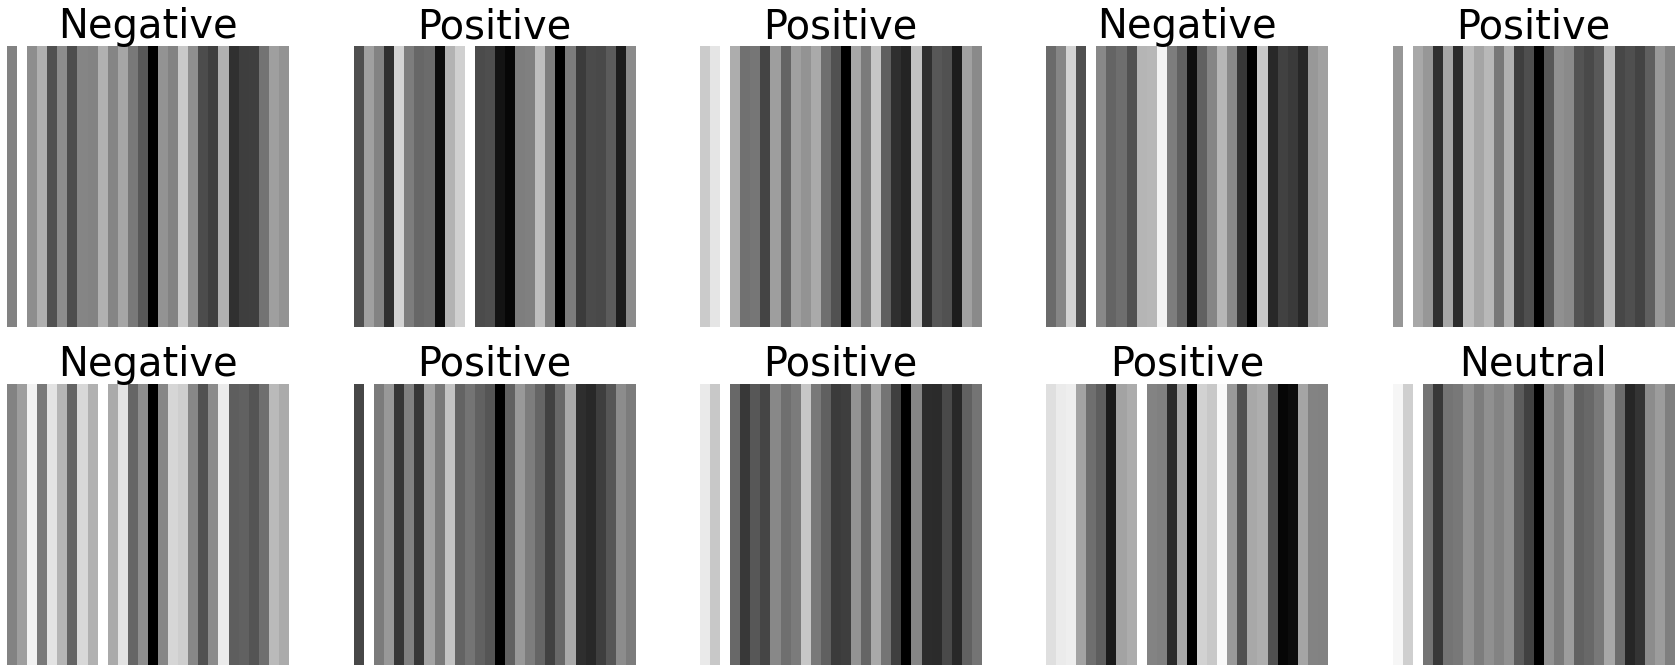

In [0]:
classes = ["Positive" , "Neutral" , "Negative"]

def show_batch(all_x, all_y):
    plt.figure(figsize=(30,30))
    for n in range(0,10):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(all_x[n].squeeze(), cmap='gray')
          plt.title(classes[all_y[n]], fontsize=40)
          plt.axis('off')

show_batch(X_train_img, y_train_np)

In [0]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    # filename = os.path.join(model_name, "digits_over_latent.png")
    # #display a 30x30 2D manifold of digits
    # n = 1
    # digit_size = 28
    # figure = np.zeros((digit_size * n, digit_size * n))
    # # # linearly spaced coordinates corresponding to the 2D plot
    # # # of digit classes in the latent space
    # grid_x = np.linspace(-4, 4, n)
    # grid_y = np.linspace(-4, 4, n)[::-1]

    # for i, yi in enumerate(grid_y):
    #     for j, xi in enumerate(grid_x):
    #         z_sample = np.array([[xi, yi]])
    #         x_decoded = decoder.predict(z_sample)
    #         digit = x_decoded[0].reshape(digit_size, digit_size)
    #         figure[i * digit_size: (i + 1) * digit_size,
    #                j * digit_size: (j + 1) * digit_size] = digit

    # plt.figure(figsize=(10, 10))
    # start_range = digit_size // 2
    # end_range = (n - 1) * digit_size + start_range + 1
    # pixel_range = np.arange(start_range, end_range, digit_size)
    # sample_range_x = np.round(grid_x, 1)
    # sample_range_y = np.round(grid_y, 1)
    # plt.xticks(pixel_range, sample_range_x)
    # plt.yticks(pixel_range, sample_range_y)
    # plt.xlabel("z[0]")
    # plt.ylabel("z[1]")
    # plt.imshow(figure, cmap='Greys_r')
    # plt.savefig(filename)
    # plt.show()


# Our dataset
(x_train, y_train), (x_test, y_test) = (X_train_img , y_train_np), (X_val_img, y_valid_np)

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 20
epochs = 200

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='selu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='selu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 20)           10260       dense_31[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 20)           10260       dense_31[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 20), (None, 20),  422440    
_________________________________________________________________
decoder (Model)              (None, 784)               412944    
Total params: 835,384
Trainable params: 835,384
Non-trainable params: 0
_________________________________________________________________
Train on 2661 samples, validate on 766 samples
Epoch 1/200
2661/2661 [==============================] - 0s 75us/step - loss: 544.1853 - val_loss: 533.2746
Epoch 2/200
2661/2661 [==============================] - 0s 29us/step - loss: 523.2484 - val_loss: 512.4913
Epoch 3/200
2661/2661 [==============================] - 0s 29us/step - loss: 498.3877 - val_loss: 479.2290
Epoch 4/200


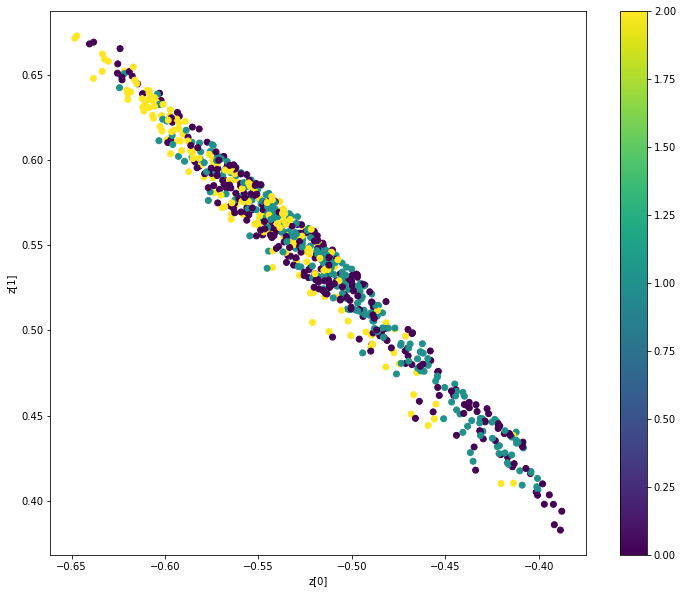

In [0]:
import tensorflow
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = mse(inputs, outputs)

reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
opt = tensorflow.keras.optimizers.Adam(1e-4)
vae.compile(optimizer=opt)
vae.summary()
plot_model(vae,
            to_file='vae_mlp.png',
            show_shapes=True)

# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

plot_results(models,
              data,
              batch_size=batch_size,
              model_name="vae_mlp")

In [0]:
print(x_train.shape)
print(x_test.shape)

(2661, 784)
(766, 784)


In [0]:
z_mean_train, _, _ = encoder.predict(x_train, batch_size=batch_size)
z_mean_train = np.asarray(z_mean_train)

print(z_mean_train.shape)

z_mean_val, _, _ = encoder.predict(x_test, batch_size=batch_size)
z_mean_val = np.asarray(z_mean_val)

print(z_mean_val.shape)

(2661, 20)
(766, 20)


In [0]:
import pickle

pickle.dump( z_mean_train, open( "/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/VAE/z_mean_train_5.pkl", "wb" ) )
pickle.dump( z_mean_val, open( "/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/VAE/z_mean_val_5.pkl", "wb" ) )

In [0]:
# Leila's experimentation below

inputs = tf.keras.Input(shape=z_mean_val.shape[1:])

x = tf.keras.layers.Dense(100, activation='selu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dense(50, activation='selu', kernel_regularizer=tf.keras.regularizers.l2())(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation = 'selu', kernel_regularizer=tf.keras.regularizers.l2())(x)

# inputs = tf.keras.layers.Input(shape=(28, 28, 1))
# x = tf.keras.layers.Conv2D(
#     filters=32, kernel_size=3, strides=(2, 2), activation='relu')(inputs)
# x = tf.keras.layers.Conv2D(
#     filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(100)(x)
outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

model = tf.keras.Model(inputs=[inputs] , outputs=[outputs])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate= 1e-2, #This LR came from the hyperparameter tuning using the HyperAS (modified HyperOpt for Keras) -- randomized search
      decay_steps=10000,
      decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=e86facf02e98b8d6244896b1688b6313f43cbf1f131aca90b8cebf8ad00370f8
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=f4a4be9463f4a893141321e0adaa20bbe5995ee9ec651ed4a1e7d8fb66abd081
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
# Credit goes to Tom for help with this version! 

MODEL_NAME = "ensemble-vae-v3"

from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

def build_model(hp):
    Path(f"drive/My Drive/Machine-Learning-Projects/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
    checkpoint_path = "drive/My Drive/Machine-Learning-Projects/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        save_weights_only=False,
        save_best_only=True,
        period=1
    )

    def create_model(inputs):
        x = tf.keras.layers.Dense(hp.Int('units', min_value=8, max_value=128, step=8), activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
        x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
        x = tf.keras.layers.Dense(50, activation='selu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                      loss = 'sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    inputs = tf.keras.Input(shape=(z_mean_train.shape[1]))
    model = create_model(inputs)
    # model.summary()
    return model


In [0]:
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='fc-prediction',
    project_name='fc-prediction'
)
tuner.search_space_summary()

tuner.search(z_mean_train, y_train_np,
             epochs=30,
             validation_data=(z_mean_val, y_valid_np),
             verbose=0)


INFO:tensorflow:Oracle triggered exit


In [0]:
print(tuner.results_summary())

None


In [0]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
initial_epochs = 200

def create_final_model(inputs):
        x = tf.keras.layers.Dense(104, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
        x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
                      ,loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

inputs = tf.keras.Input(shape=(z_mean_train.shape[1]))

#save_path = "/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/leila-all_samples_self_dense_vae_keras_classifier-v10-z-val-split-with-face.h5"
save_path = "/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/all_samples_dense_vae_classifier-v4-la.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint(save_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model = create_final_model(inputs)
history = model.fit(
          x=z_mean_train, y=y_train_np,
          epochs=initial_epochs, callbacks=[es, mc],
          validation_data=(z_mean_val, y_valid_np), batch_size=32)

Epoch 1/200
82/84 [============================>.] - ETA: 0s - loss: 1.2055 - accuracy: 0.3468
Epoch 00001: val_accuracy improved from -inf to 0.24021, saving model to /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/all_samples_dense_vae_classifier-v4-la.h5
84/84 [==============================] - 1s 10ms/step - loss: 1.2043 - accuracy: 0.3469 - val_loss: 1.1296 - val_accuracy: 0.2402
Epoch 2/200
84/84 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.3615
Epoch 00002: val_accuracy improved from 0.24021 to 0.41645, saving model to /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/all_samples_dense_vae_classifier-v4-la.h5
84/84 [==============================] - 0s 5ms/step - loss: 1.1029 - accuracy: 0.3615 - val_loss: 1.1216 - val_accuracy: 0.4164
Epoch 3/200
70/84 [========================>.....] - ETA: 0s - loss: 1.0984 - accuracy: 0.3629
Epoch 00003: val_accuracy did not improve from 0.41645
84/84 [=================

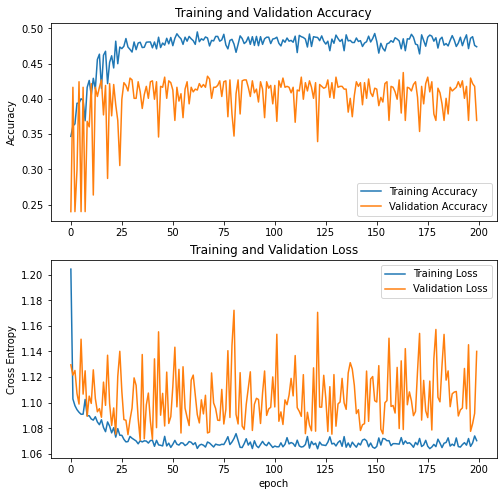

In [0]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Load Best Model to Perform Prediction

In [0]:
# load_path = "/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/all_samples_dense_vae_classifier-v4-la.h5"
# model = tf.keras.models.load_model(load_path)

# z_mean_train = np.load('/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/VAE/z_mean_train_5.pkl', allow_pickle=True)
# z_mean_val = np.load('/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/VAE/z_mean_val_5.pkl', allow_pickle=True)

y_pred = model.predict(z_mean_val)

In [0]:
y_valid_labels = y_val_np + 1
print(y_valid_labels)

y_pred_labels = np.argmax(y_pred, axis=1) + 1
print(y_pred_labels)

[3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 2 3 3 1 1 2 1 2 1 2 1 1 1 1 1 3 3 3 3 3 2 3 3 2 2 3 3 3 3 3 3 3 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 1 2 3 3 3 3 1 1 1 1 1 1 1 1 2 2 3 2 1 3 3 2 3 3 3 3 2
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1
 1 1 1 1 2 1 1 1 2 2 2 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1 3 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 1 1 2 1 2 2 2 2 2 2 1 2 1 1 1 1 2 1 2 1 1
 3 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 1 2 2 2 2 1 2 2 1 1 1 1 1 2 1 2 2 2
 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 1 2 2 2 1 2 2 2 1 2 2 2 2 1 1 1 1 1 1 1 2 3 3 2 3 2
 3 3 3 3 3 2 3 3 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3
 3 2 3 2 2 3 3 3 3 3 3 3 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Accuracy: 0.36945169712793735


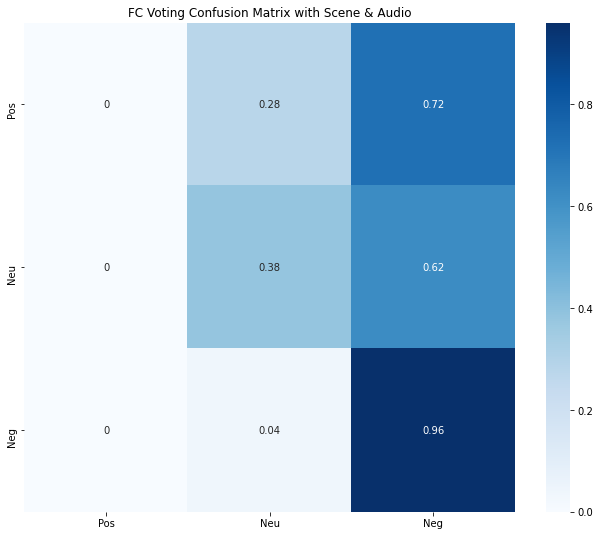

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("FC Voting Confusion Matrix with Scene & Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_true_final, y_pred_final, target_names=classes, digits=3))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Pos      0.000     0.000     0.000       302
         Neu      0.538     0.382     0.447       280
         Neg      0.310     0.957     0.469       184

    accuracy                          0.369       766
   macro avg      0.283     0.446     0.305       766
weighted avg      0.271     0.369     0.276       766



## t-SNE of the Validation Encodings

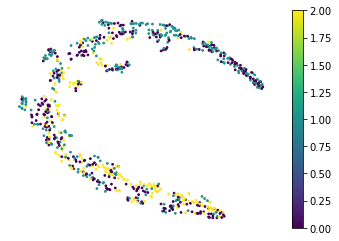

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

z_mean_val = np.load('/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/VAE/z_mean_val_5.pkl' , allow_pickle=True)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(z_mean_val)

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid_np, s=3)
plt.colorbar()
plt.axis('off')
plt.show()

## Annealed Importance in Sampling
